In [ ]:
!pip install -q git+https://github.com/facebookresearch/segment-anything.git
!pip install -q -U opencv-python pycocotools matplotlib onnxruntime onnx bitsandbytes
!pip install -q diffusers

!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

In [2]:
import cv2
import numpy as np

image = cv2.imread("/kaggle/input/sirius-2024-cv/sirius_data/15.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
resized_image = cv2.resize(image, (image.shape[1] // 8 * 8, image.shape[0] // 8 * 8)) 

In [ ]:
from segment_anything import SamPredictor, sam_model_registry, SamAutomaticMaskGenerator
import torch


device = "cuda" if torch.cuda.is_available() else "cpu"

sam = sam_model_registry["default"](checkpoint="/kaggle/working/sam_vit_h_4b8939.pth").to(device=device)
predictor = SamPredictor(sam)
mask_generator = SamAutomaticMaskGenerator(sam, points_per_side=32, points_per_batch=64)

In [4]:
masks = mask_generator.generate(resized_image)

In [6]:
# predictor.set_image(image)

# masks, scores, logits = predictor.predict(
#     point_coords=input_point,
#     point_labels=input_label,
#     multimask_output=True,
# )

In [5]:
import matplotlib.pyplot as plt


def show_mask(mask, ax, random_color=False):
    color = np.concatenate([np.random.random(3), np.array([1])], axis=0)
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2)) 

In [6]:
def find_best_mask(masks):
    idx = 0 if masks[0]["bbox"][0] < 10 else 1
    best_mask = masks[idx]["segmentation"] * 1
    
    return best_mask

In [7]:
from PIL import Image

best_mask = find_best_mask(masks).astype("uint8")

fill_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(10,10))
clean_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(20,20))

filled_mask = cv2.morphologyEx(best_mask, cv2.MORPH_CLOSE, fill_kernel)
cleaned_mask = cv2.morphologyEx(filled_mask, cv2.MORPH_OPEN, clean_kernel)
blurred_mask = cv2.GaussianBlur(cleaned_mask, (35, 35), 0)

inverted_mask = np.logical_not(blurred_mask) * 1

In [8]:
PIL_mask = Image.fromarray(blurred_mask * 255)

In [9]:
cropped_object = cv2.bitwise_and(resized_image, resized_image, mask=inverted_mask.astype("uint8"))
RGBA_cropped_object = np.dstack((cropped_object, np.zeros((cropped_object.shape[0], cropped_object.shape[1]),dtype=np.uint8)+255))
alpha_channel = (RGBA_cropped_object[:, :, 0:3] == [0,0,0]).all(2)
RGBA_cropped_object[alpha_channel] = (0,0,0,0)

PIL_RGBA_cropped_object = Image.fromarray(RGBA_cropped_object)

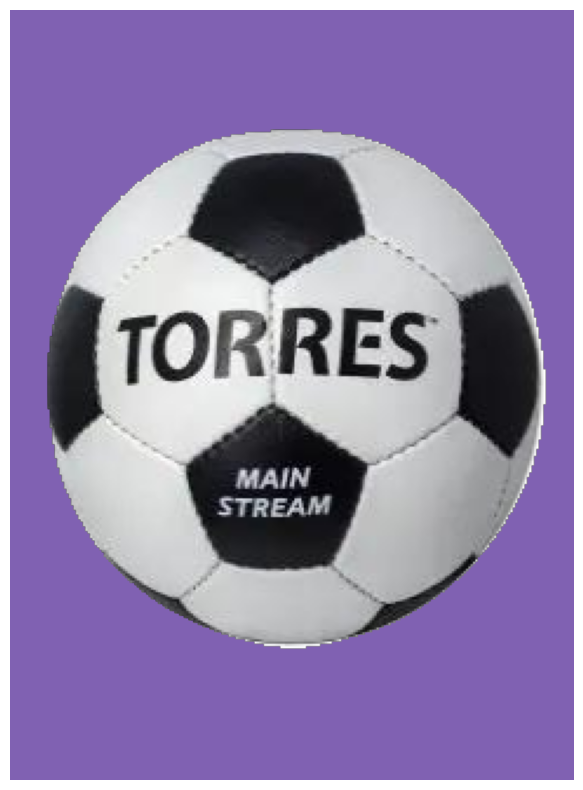

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
plt.imshow(resized_image)
show_mask(blurred_mask, plt.gca())
plt.axis('off')
plt.show()  

In [ ]:
from diffusers import AutoPipelineForInpainting
from diffusers.utils import load_image
import torch

pipe = AutoPipelineForInpainting.from_pretrained("Lykon/dreamshaper-8-inpainting", torch_dtype=torch.float16).to("cuda")
pipe.enable_model_cpu_offload()

In [12]:
resized_pil_image = load_image(Image.fromarray(resized_image))
mask_image = load_image(PIL_mask)

prompt = "an object in a smooth background, smooth texture, realistic"
negative_prompt = "ugly, extra items"

In [13]:
generated_image = pipe(
  prompt=prompt,
  negative_prompt=negative_prompt,
  image=resized_pil_image,
  mask_image=mask_image,
  guidance_scale=15,
  num_inference_steps=20,  
  height=resized_pil_image.height,
  width=resized_pil_image.width,
  strength=0.9,
).images[0]

  0%|          | 0/18 [00:00<?, ?it/s]

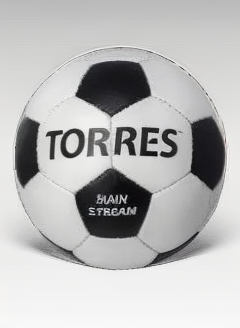

In [14]:
generated_image

In [15]:
generated_image_as_RGBA = generated_image.convert("RGBA")
generated_image_as_RGBA.paste(PIL_RGBA_cropped_object, (0, 0), PIL_RGBA_cropped_object)

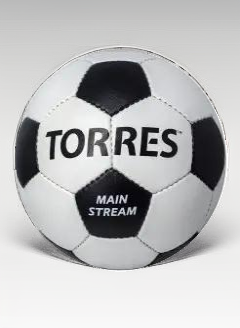

In [16]:
generated_image_as_RGBA

In [ ]:
from PIL import Image
import requests
from transformers import Blip2Processor, Blip2ForConditionalGeneration
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

processor = Blip2Processor.from_pretrained("Salesforce/blip2-opt-2.7b")
model = Blip2ForConditionalGeneration.from_pretrained("Salesforce/blip2-opt-2.7b", torch_dtype=torch.float16).to(device)

In [18]:
image = generated_image_as_RGBA
prompt = ""
inputs = processor(images=image, text=prompt, return_tensors="pt").to(device, torch.float16)

outputs = model.generate(**inputs)
generated_text = processor.batch_decode(outputs, skip_special_tokens=True)[0].strip()

print(generated_text)

a soccer ball with the word torres on it


In [20]:
outp = pipe(generated_text)
print(outp[0]["translation_text"])

футбольный мяч со словом Торрес на нем
